In [213]:
import numpy as np
from numpy import trapz
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,binned_statistic
import scipy.integrate as integrate
from scipy.stats import norm
from astropy.io import ascii, fits
from astropy import wcs
from pymoc.util.catalog import catalog_to_moc
from scipy.stats import norm,kstest

from astropy.table import Table,vstack,Column,join
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.coordinates import SkyCoord,match_coordinates_sky

import emcee
import time
import corner
import herschelhelp
from matplotlib.colors import LogNorm
from lifelines import KaplanMeierFitter
from herschelhelp import image_plotting
from herschelhelp_internal.utils import inMoc

In [138]:
def log_normal(x,mean,sig,theta):
    y = np.exp(-(np.log((x-theta)/mean))**2/(2*sig**2)) / ( (x-theta) * sig*np.sqrt(2*np.pi))
    return(y)

In [26]:
def get_center(bins):
    """
    Get the central positions for an array defining bins
    """
    return (bins[:-1] + bins[1:]) / 2

In [199]:
def casey_2012(wave,beta,T,wave_0):
    h = 6.63E-34
    K = 1.38E-23
    c = 3E8
    freq = c/(wave*1E-6)
    print(freq)
    vo = c/(wave_0*1E-6)
    
    flux = (1 - np.exp(-(freq/vo)**beta))*(freq)**3 / (np.exp(freq*h/(K*T)) - 1)
    return(flux)

In [27]:
def delhaize_fit(z):
    y = 2.88*(1+z)**-0.19
    return(y)

In [122]:
def gurkan_fit(L250):
    L150 = L250**1.15*10**(-5.05)
    return(L150)

In [4]:
def straight_line(x,params):
    m,c = params
    y = m*x + c
    return(y)

In [109]:
def gaus_cdf(x,params):
    mean,sig = params
    return(norm.cdf(x,mean,sig))

In [5]:
def donley_agn(i1,i2,i3,i4,c1=0.08,c2=0.15,c3=1.21,c4=0.27):
    '''
    returns a masked column for the sources with True corresponding to AGN selected bby the Donley et al 2012
    selection criteria.
    NOTE: this function can be used to see the affects or changing the criteria slightly
    '''
    x = np.log10(i3/i1)
    y = np.log10(i4/i2)
    
    crit1 = (x>=c1) & (y>=c2) & (y>=(c3*x-c4)) & (y<=(c3*x+c4))
    crit2 = (i2>i1) & (i3>i2) & (i4>i3)
    mask = crit1 & crit2
    
    plt.scatter(x,y,s=1.0,c='blue')
    plt.scatter(x[mask],y[mask],s=1.0,c='red')
    plt.show()
    
    return(mask)

In [8]:
vla_data = Table.read('data/VLA_3GHz_counterpart_array_20170210_paper_delvecchio_et_al.fits.txt')
vla_data[0]

ID_VLA3,RA_VLA3,DEC_VLA3,Z_BEST,Z_TYPE,FLUX_INT_3GHz,Lradio_10cm,Lradio_21cm,L_TIR_SF,flag_herschel3,Mstar,SFR_IR,NUV_R,XRAY_AGN,MIR_AGN,SED_AGN,Radio_excess,Class
int32,float64,float64,float32,bytes17,float64,float64,float64,float64,bytes25,float64,float64,float64,int32,int32,int32,int32,bytes16
1,149.647714,2.095465,1.5457,phot,16147.04,25.839253,25.717876,11.6626,true,11.224274,45.983324,2.416443,0,0,0,1,MLAGN


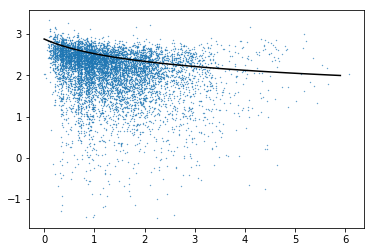

In [17]:
fir_lum_watts = 10**vla_data['L_TIR_SF']*3.8E26
rad_lum_watts = 10**vla_data['Lradio_21cm']
q = np.log10(fir_lum_watts/3.75E12) -np.log10(rad_lum_watts)

x = vla_data['Z_BEST']
plt.scatter(x,q,s=0.1)

x = np.arange(0,6,0.1)
y = delhaize_fit(x)
plt.plot(x,y,c='black')
plt.show()

In [128]:
help_masterlist = Table.read('../../../HELP/dmu_products/dmu32/dmu32_ELAIS-N1/data/ELAIS-N1_20171020.fits')
help_masterlist[0]

help_id,field,ra,dec,hp_idx,ebv,redshift,zspec,f_wfc_u,ferr_wfc_u,f_ap_wfc_u,ferr_ap_wfc_u,m_wfc_u,merr_wfc_u,m_ap_wfc_u,merr_ap_wfc_u,flag_wfc_u,f_megacam_u,ferr_megacam_u,f_ap_megacam_u,ferr_ap_megacam_u,m_megacam_u,merr_megacam_u,m_ap_megacam_u,merr_ap_megacam_u,flag_megacam_u,f_suprime_g,ferr_suprime_g,f_ap_suprime_g,ferr_ap_suprime_g,m_suprime_g,merr_suprime_g,m_ap_suprime_g,merr_ap_suprime_g,flag_suprime_g,f_megacam_g,ferr_megacam_g,f_ap_megacam_g,ferr_ap_megacam_g,m_megacam_g,merr_megacam_g,m_ap_megacam_g,merr_ap_megacam_g,flag_megacam_g,f_gpc1_g,ferr_gpc1_g,f_ap_gpc1_g,ferr_ap_gpc1_g,m_gpc1_g,merr_gpc1_g,m_ap_gpc1_g,merr_ap_gpc1_g,flag_gpc1_g,f_wfc_g,ferr_wfc_g,f_ap_wfc_g,ferr_ap_wfc_g,m_wfc_g,merr_wfc_g,m_ap_wfc_g,merr_ap_wfc_g,flag_wfc_g,f_suprime_r,ferr_suprime_r,f_ap_suprime_r,ferr_ap_suprime_r,m_suprime_r,merr_suprime_r,m_ap_suprime_r,merr_ap_suprime_r,flag_suprime_r,f_gpc1_r,ferr_gpc1_r,f_ap_gpc1_r,ferr_ap_gpc1_r,m_gpc1_r,merr_gpc1_r,m_ap_gpc1_r,merr_ap_gpc1_r,flag_gpc1_r,f_wfc_r,ferr_wfc_r,f_ap_wfc_r,ferr_ap_wfc_r,m_wfc_r,merr_wfc_r,m_ap_wfc_r,merr_ap_wfc_r,flag_wfc_r,f_megacam_r,ferr_megacam_r,f_ap_megacam_r,ferr_ap_megacam_r,m_megacam_r,merr_megacam_r,m_ap_megacam_r,merr_ap_megacam_r,flag_megacam_r,f_gpc1_i,ferr_gpc1_i,f_ap_gpc1_i,ferr_ap_gpc1_i,m_gpc1_i,merr_gpc1_i,m_ap_gpc1_i,merr_ap_gpc1_i,flag_gpc1_i,f_suprime_i,ferr_suprime_i,f_ap_suprime_i,ferr_ap_suprime_i,m_suprime_i,merr_suprime_i,m_ap_suprime_i,merr_ap_suprime_i,flag_suprime_i,f_wfc_i,ferr_wfc_i,f_ap_wfc_i,ferr_ap_wfc_i,m_wfc_i,merr_wfc_i,m_ap_wfc_i,merr_ap_wfc_i,flag_wfc_i,f_gpc1_z,ferr_gpc1_z,f_ap_gpc1_z,ferr_ap_gpc1_z,m_gpc1_z,merr_gpc1_z,m_ap_gpc1_z,merr_ap_gpc1_z,flag_gpc1_z,f_wfc_z,ferr_wfc_z,f_ap_wfc_z,ferr_ap_wfc_z,m_wfc_z,merr_wfc_z,m_ap_wfc_z,merr_ap_wfc_z,flag_wfc_z,f_megacam_z,ferr_megacam_z,f_ap_megacam_z,ferr_ap_megacam_z,m_megacam_z,merr_megacam_z,m_ap_megacam_z,merr_ap_megacam_z,flag_megacam_z,f_suprime_z,ferr_suprime_z,f_ap_suprime_z,ferr_ap_suprime_z,m_suprime_z,merr_suprime_z,m_ap_suprime_z,merr_ap_suprime_z,flag_suprime_z,f_suprime_n921,ferr_suprime_n921,f_ap_suprime_n921,ferr_ap_suprime_n921,m_suprime_n921,merr_suprime_n921,m_ap_suprime_n921,merr_ap_suprime_n921,flag_suprime_n921,f_gpc1_y,ferr_gpc1_y,f_ap_gpc1_y,ferr_ap_gpc1_y,m_gpc1_y,merr_gpc1_y,m_ap_gpc1_y,merr_ap_gpc1_y,flag_gpc1_y,f_suprime_y,ferr_suprime_y,f_ap_suprime_y,ferr_ap_suprime_y,m_suprime_y,merr_suprime_y,m_ap_suprime_y,merr_ap_suprime_y,flag_suprime_y,f_ukidss_j,ferr_ukidss_j,f_ap_ukidss_j,ferr_ap_ukidss_j,m_ukidss_j,merr_ukidss_j,m_ap_ukidss_j,merr_ap_ukidss_j,flag_ukidss_j,f_ukidss_k,ferr_ukidss_k,f_ap_ukidss_k,ferr_ap_ukidss_k,m_ukidss_k,merr_ukidss_k,m_ap_ukidss_k,merr_ap_ukidss_k,flag_ukidss_k,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,m_irac_i1,merr_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,flag_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i2,merr_irac_i2,m_ap_irac_i2,merr_ap_irac_i2,flag_irac_i2,f_irac_i3,ferr_irac_i3,f_ap_irac_i3,ferr_ap_irac_i3,m_irac_i3,merr_irac_i3,m_ap_irac_i3,merr_ap_irac_i3,flag_irac_i3,f_irac_i4,ferr_irac_i4,f_ap_irac_i4,ferr_ap_irac_i4,m_irac_i4,merr_irac_i4,m_ap_irac_i4,merr_ap_irac_i4,flag_irac_i4,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,flag_cigale,flag_cigale_opt,flag_cigale_ir,flag_cigale_ironly,stellarity,stellarity_origin,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,zspec_qual,zspec_association_flag
,,deg,deg,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [6]:
lofar_data = Table.read('../lofar/deep_fields/ELAIS-N1/data/data_release/lofar_XID+_merged.fits')
lofar_data[0]

id,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,FLAG_OVERLAP,Separation,help_id,RA_HELP,DEC_HELP,EBV,Z_SPEC,CLASS_STAR,MegaCam.u.res,MegaCam.u.res_err,PS1.g.res,PS1.g.res_err,PS1.r.res,PS1.r.res_err,PS1.i.res,PS1.i.res_err,PS1.z.res,PS1.z.res_err,PS1.y.res,PS1.y.res_err,HSC-g_mod.res,HSC-g_mod.res_err,HSC-r_mod.res,HSC-r_mod.res_err,HSC-i_mod.res,HSC-i_mod.res_err,HSC-z_mod.res,HSC-z_mod.res_err,HSC-Y_mod.res,HSC-Y_mod.res_err,wHSC-NB921_mod.res,wHSC-NB921_mod.res_err,UKIDSS.J.res,UKIDSS.J.res_err,UKIDSS.K.res,UKIDSS.K.res_err,IRAC.I1.res,IRAC.I1.res_err,IRAC.I2.res,IRAC.I2.res_err,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,IRAC.I3.res,IRAC.I3.res_err,IRAC.I4.res,IRAC.I4.res_err,mips_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,pacs_green,FErr_PACS_100_u,FErr_PACS_100_l,pacs_red,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,spire_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,spire_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,spire_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,AGN,optAGN,IRAGN,XrayAGN,redshift,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,hp_idx_11,hp_depth_cluster,mips_24_err,pacs_green_err,pacs_red_err,spire_250_err,spire_350_err,spire_500_err
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,bytes22,bytes17,bytes22,int64,int64,int64,float32,float32,float64,float64,int64,int64,int32,int64,float64,bytes27,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float32,float32,bool,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,bool,bool,bool,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,bytes6,int64,int32,float64,float64,float64,float64,float64,float64
ILTJ155957.58+550052.4,239.98990167026162,55.01456045936245,5.366954914924915e-05,8.08706707123675e-05,0.0003958345213565919,5.4160526835678236e-05,0.0003247963953282784,2.715224507873135e-05,S,0.002071920400992901,0.0016345290335764496,166.30848152559156,0.00019279093100176814,0.00012276320016402095,13.835288

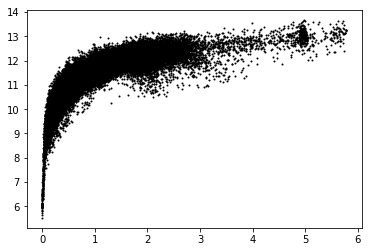

In [130]:
x = help_masterlist['redshift']
y = np.log10(help_masterlist['cigale_dustlumin']/3.8E26)
plt.scatter(x,y,s=1,c='black')
plt.show()

In [230]:
mask = ~np.isnan(help_masterlist['cigale_dustlumin'])
help_ldust = help_masterlist[mask]

ras = lofar_data['optRA']
decs = lofar_data['optDec']
mask = np.isnan(lofar_data['optRA'])
ras[mask] = lofar_data['RA'][mask]
decs[mask] = lofar_data['DEC'][mask]
lofar_coords = SkyCoord(ras,decs,unit='deg')
moc = catalog_to_moc(lofar_coords,15,12)

moc_mask = inMoc(help_ldust['ra'],help_ldust['dec'],moc)
help_ldust = help_ldust[moc_mask]

In [231]:
help_coords = SkyCoord(help_ldust['ra'],help_ldust['dec'],unit='deg')
ras = lofar_data['optRA']
decs = lofar_data['optDec']
mask = np.isnan(lofar_data['optRA'])
ras[mask] = lofar_data['RA'][mask]
decs[mask] = lofar_data['DEC'][mask]
lofar_coords = SkyCoord(ras,decs,unit='deg')

idx_help,d2d,_ = match_coordinates_sky(lofar_coords,help_coords)
#lofar_coords.match_to_catalog_sky(help_coords)
#idx_help,idx_lofar,d2d = lofar_coords.match_to_catalog_sky(help_coords)

In [232]:
tmp = np.unique(idx_help)
idx_help_not = [i for i in range(len(help_coords)) if i not in tmp]

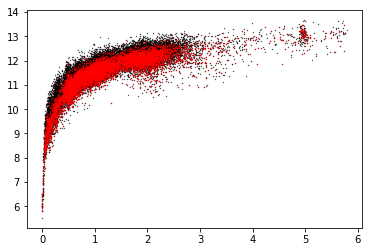

In [234]:
x = help_ldust['redshift']
y = np.log10(help_ldust['cigale_dustlumin']/3.8E26)
plt.scatter(x,y,s=0.1,c='black')

x = help_ldust['redshift'][idx_help_not]
y = np.log10(help_ldust['cigale_dustlumin'][idx_help_not]/3.8E26)
plt.scatter(x,y,s=0.1,c='red')
plt.show()

In [233]:
mask = (np.log10(help_ldust[idx_help_not]['cigale_dustlumin']/3.8E26)>12) & (help_ldust[idx_help_not]['redshift']>1) & (help_ldust[idx_help_not]['redshift']<1.1)
ras = help_ldust[idx_help_not]['ra'][mask]
decs = help_ldust[idx_help_not]['dec'][mask]

dust luminosity is 1312424532557.3186 solar_luminosities at redshift 1.0984
predicted radio flux, using q=2.7 is: 0.42571064135263675mJy
plotting 1 sources
plotting 3 sources


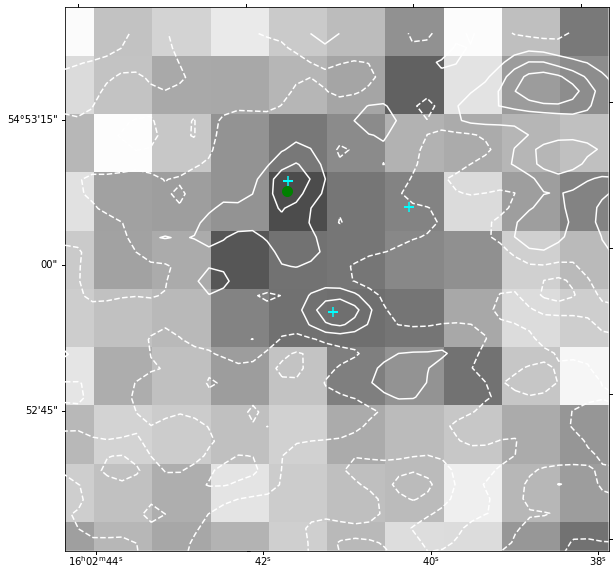

dust luminosity is 1095151167518.55 solar_luminosities at redshift 1.0071
predicted radio flux, using q=2.7 is: 0.4407102944630357mJy
plotting 2 sources
plotting 5 sources


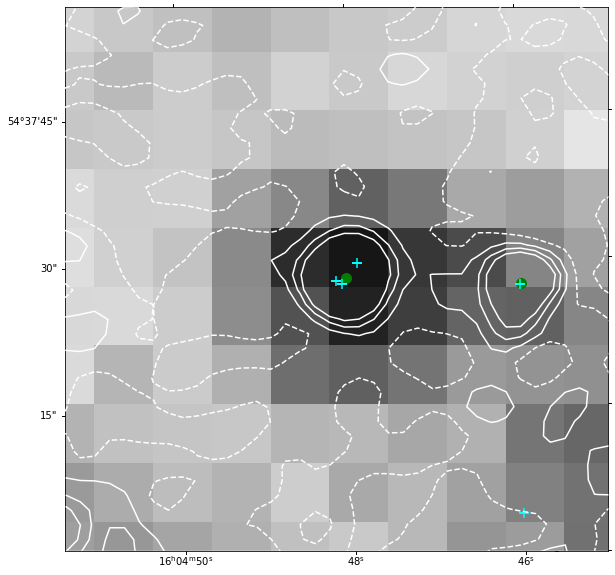

dust luminosity is 1055973289053.5828 solar_luminosities at redshift 1.0658
predicted radio flux, using q=2.7 is: 0.36915734526922556mJy
plotting 1 sources
plotting 3 sources


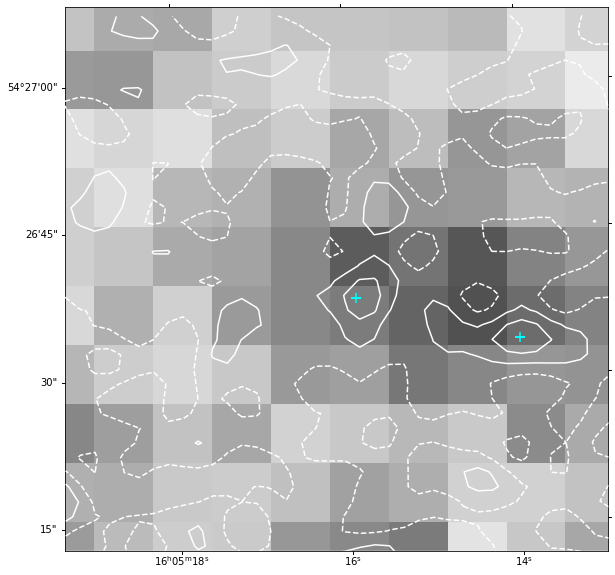

dust luminosity is 1242010266191.896 solar_luminosities at redshift 1.0463
predicted radio flux, using q=2.7 is: 0.4545798433714106mJy
plotting 3 sources
plotting 4 sources


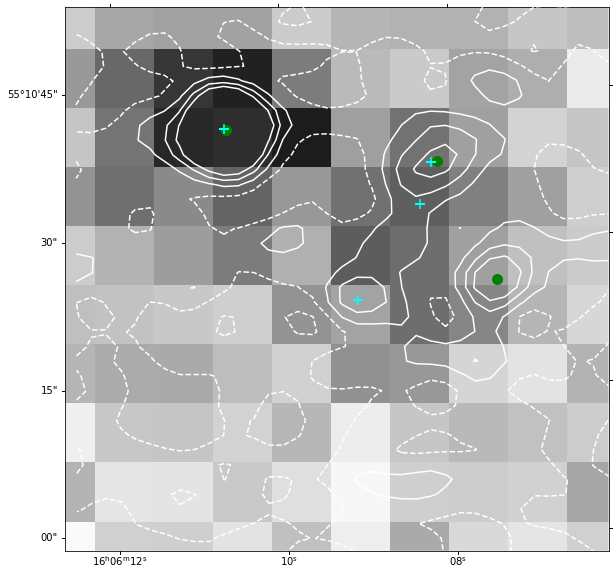

dust luminosity is 1047410162092.201 solar_luminosities at redshift 1.0676
predicted radio flux, using q=2.7 is: 0.36463156749891934mJy
plotting 1 sources
plotting 5 sources


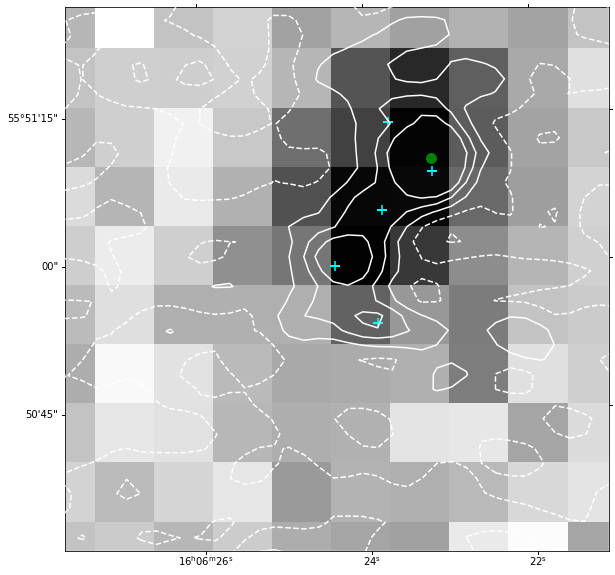

dust luminosity is 1911913553783.0913 solar_luminosities at redshift 1.0095
predicted radio flux, using q=2.7 is: 0.7648567856540273mJy
plotting 2 sources
plotting 5 sources


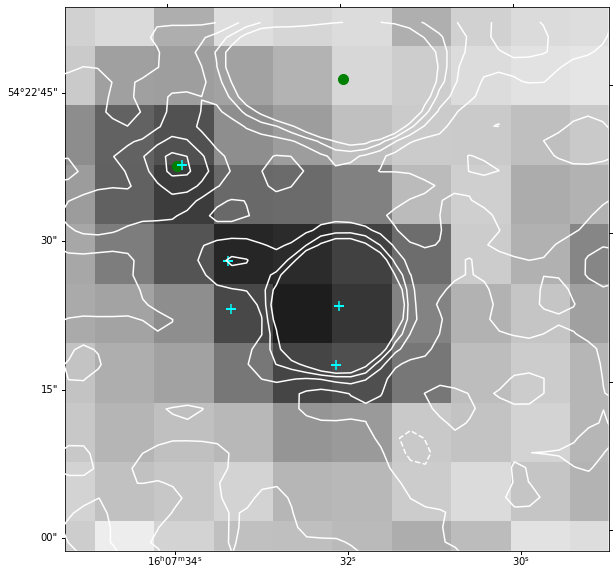

dust luminosity is 1029258234320.8525 solar_luminosities at redshift 1.0909
predicted radio flux, using q=2.7 is: 0.33959398101176275mJy
plotting 2 sources
plotting 4 sources


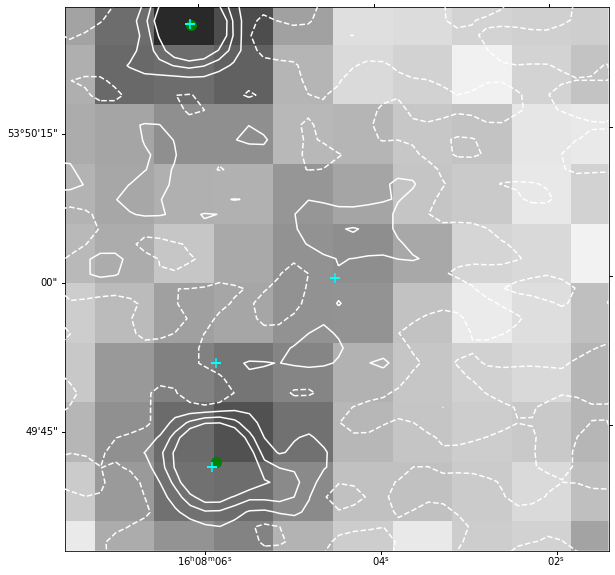

dust luminosity is 1088866018485.2192 solar_luminosities at redshift 1.0315
predicted radio flux, using q=2.7 is: 0.41288599617019806mJy
plotting 1 sources
plotting 3 sources


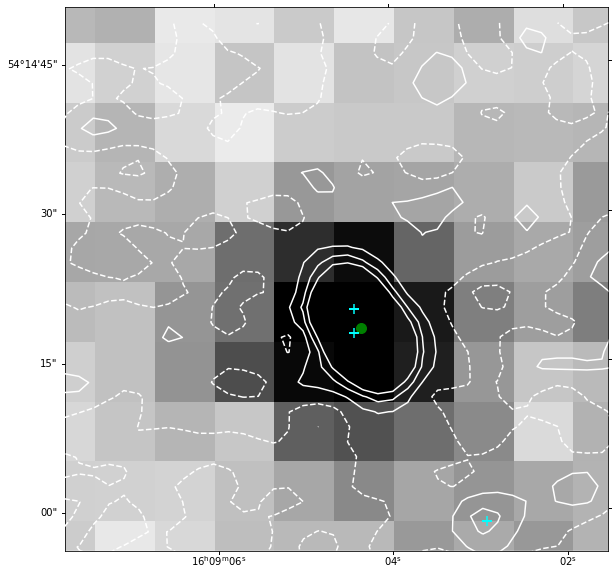

dust luminosity is 1277038801775.722 solar_luminosities at redshift 1.0644
predicted radio flux, using q=2.7 is: 0.4479001382088517mJy
plotting 1 sources
plotting 3 sources


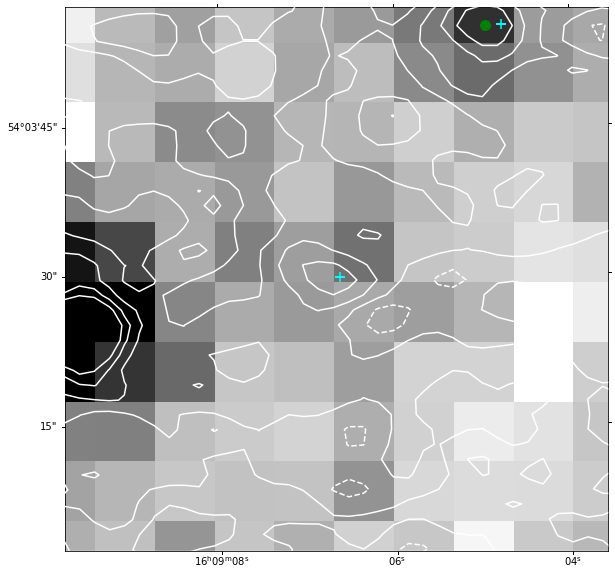

dust luminosity is 1034999889339.7261 solar_luminosities at redshift 1.0785
predicted radio flux, using q=2.7 is: 0.35132956042869445mJy
plotting 2 sources
plotting 3 sources


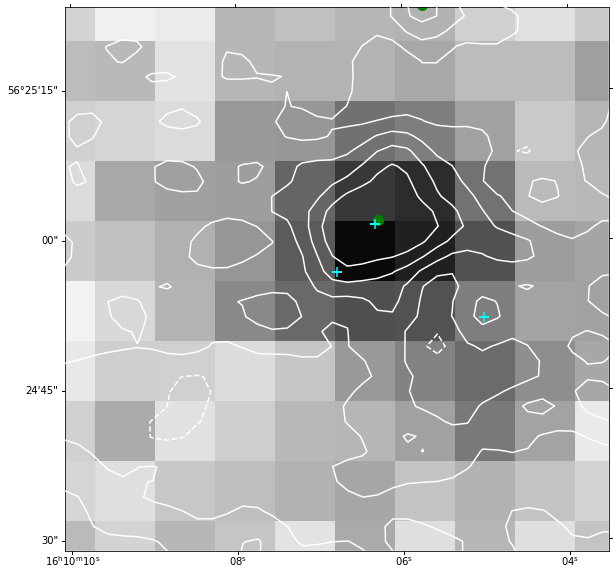

dust luminosity is 1002639410316.6813 solar_luminosities at redshift 1.049
predicted radio flux, using q=2.7 is: 0.3646270414264467mJy
plotting 2 sources
plotting 3 sources


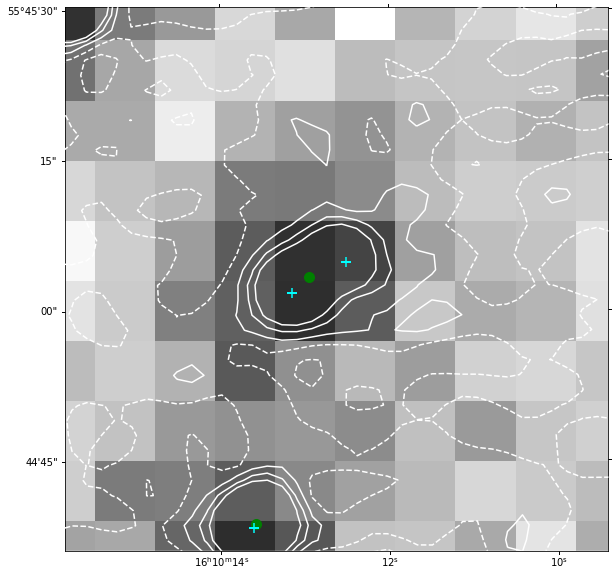

dust luminosity is 1182387912262.497 solar_luminosities at redshift 1.019
predicted radio flux, using q=2.7 is: 0.4621347179663661mJy
plotting 1 sources
plotting 2 sources


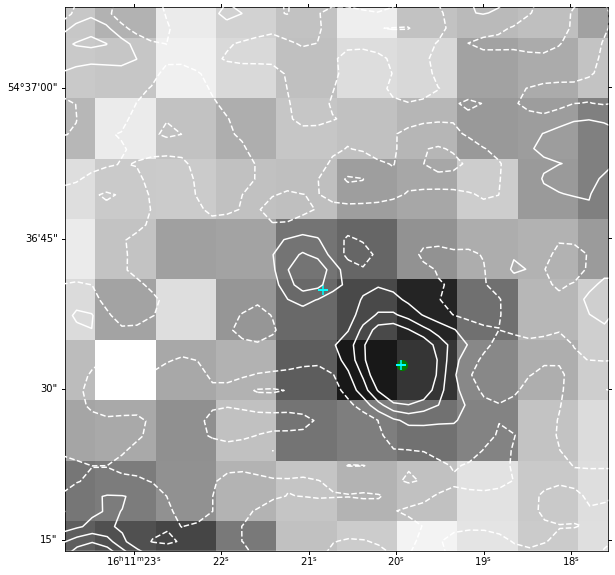

dust luminosity is 1666323978438.8289 solar_luminosities at redshift 1.0651
predicted radio flux, using q=2.7 is: 0.583481451954336mJy
plotting 2 sources
plotting 2 sources


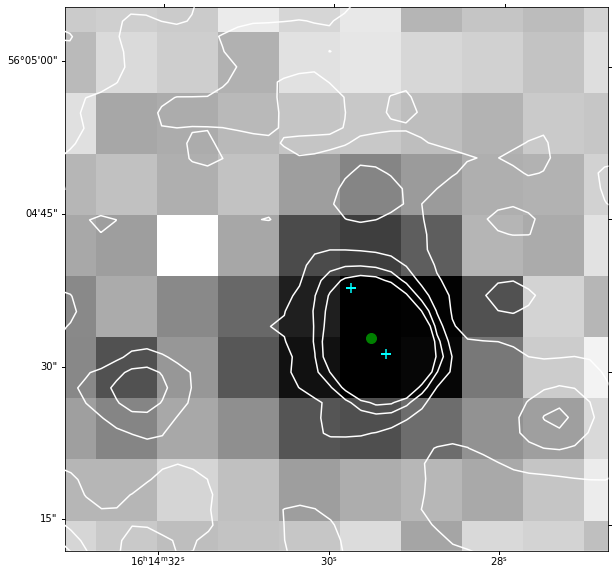

dust luminosity is 1232986134997.2434 solar_luminosities at redshift 1.0869
predicted radio flux, using q=2.7 is: 0.41054311691883133mJy
plotting 1 sources
plotting 3 sources


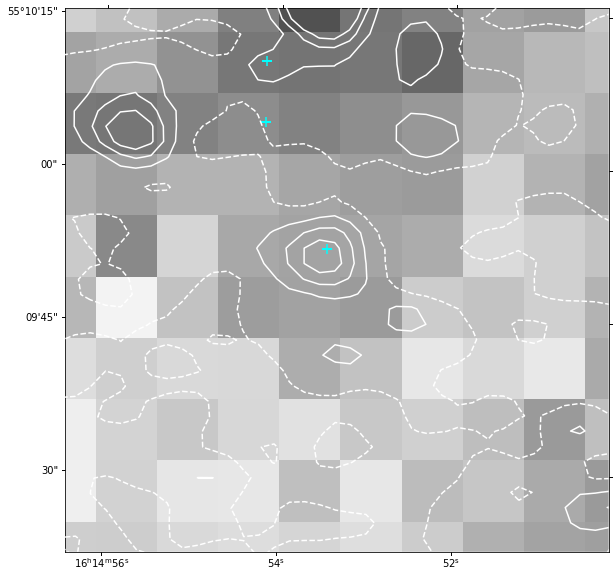

dust luminosity is 1001153759747.979 solar_luminosities at redshift 1.018
predicted radio flux, using q=2.7 is: 0.39225501824247827mJy
plotting 1 sources
plotting 1 sources


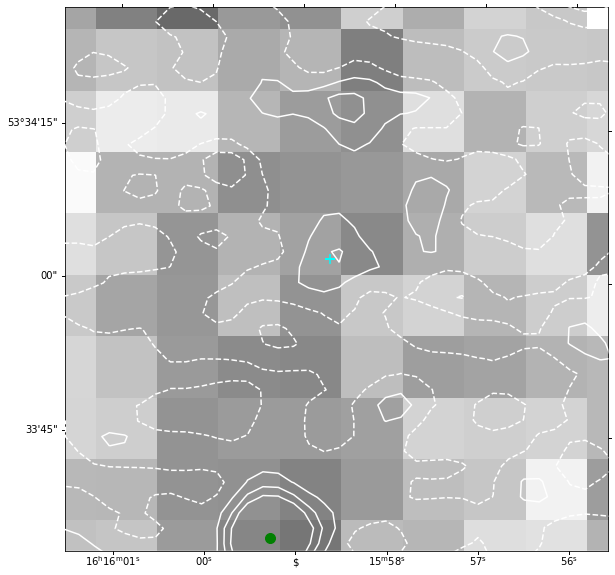

dust luminosity is 1018362437477.6906 solar_luminosities at redshift 1.0657
predicted radio flux, using q=2.7 is: 0.35609199840084205mJy
plotting 2 sources
plotting 2 sources


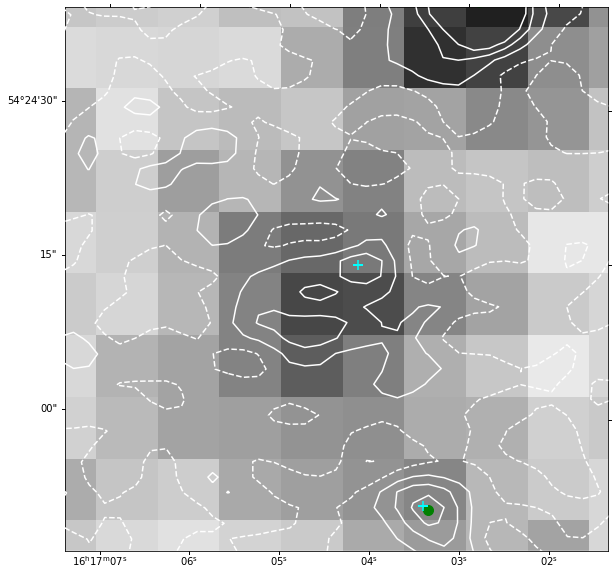

dust luminosity is 1118860923883.03 solar_luminosities at redshift 1.0815
predicted radio flux, using q=2.7 is: 0.37718328194680273mJy
plotting 0 sources
plotting 3 sources


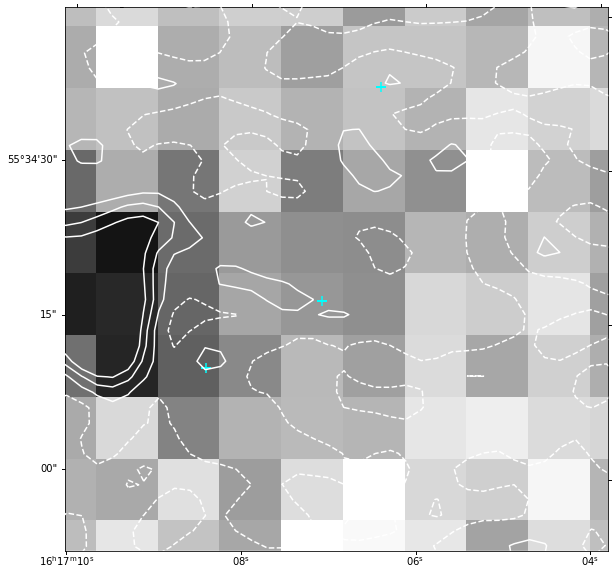

dust luminosity is 1706342904870.8237 solar_luminosities at redshift 1.0638
predicted radio flux, using q=2.7 is: 0.5993105445083433mJy
plotting 3 sources
plotting 5 sources


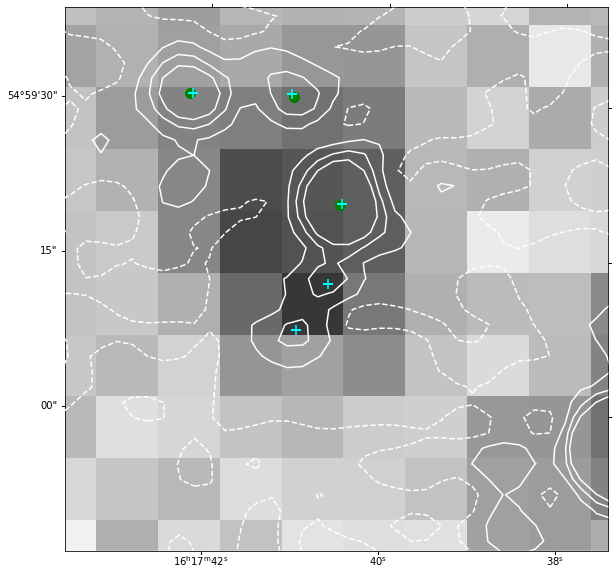

dust luminosity is 1061565493044.9359 solar_luminosities at redshift 1.0139
predicted radio flux, using q=2.7 is: 0.42011447231059806mJy
plotting 0 sources
plotting 2 sources


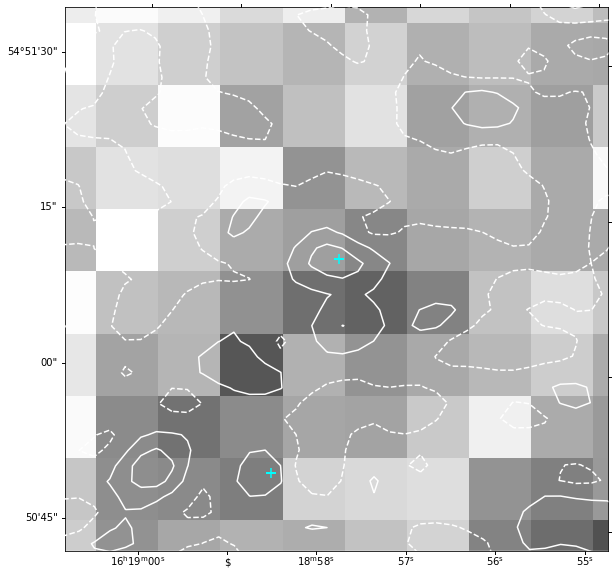

dust luminosity is 1191497815528.0784 solar_luminosities at redshift 1.0821
predicted radio flux, using q=2.7 is: 0.40111689841718473mJy
plotting 4 sources
plotting 4 sources


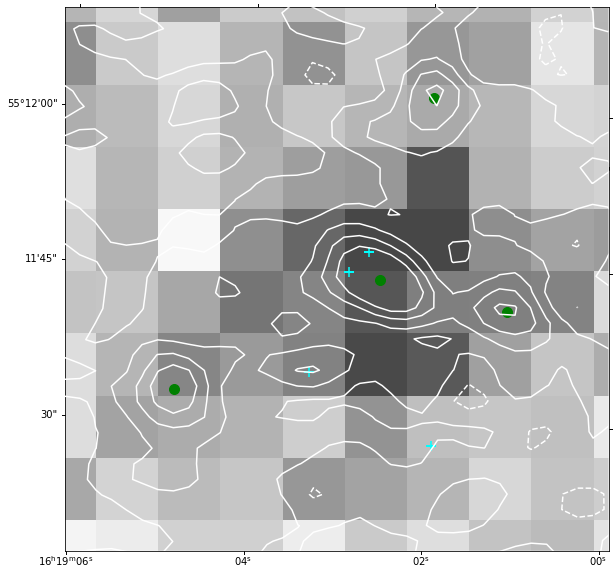

dust luminosity is 1174472942623.6072 solar_luminosities at redshift 1.0146
predicted radio flux, using q=2.7 is: 0.46400153800553257mJy
plotting 1 sources
plotting 2 sources


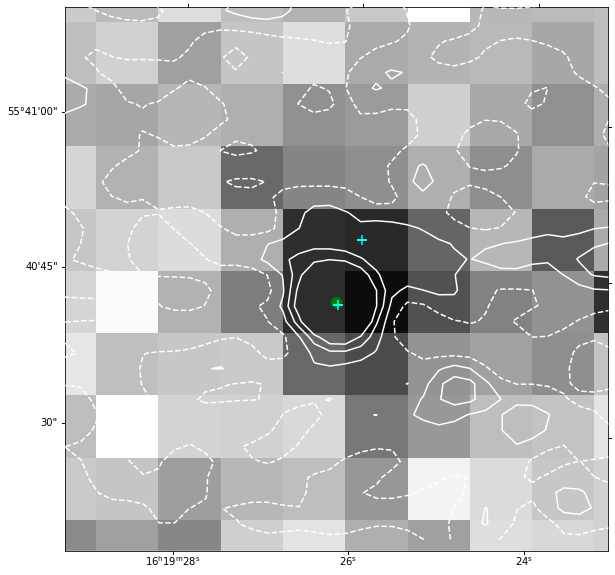

dust luminosity is 1205772759868.989 solar_luminosities at redshift 1.049
predicted radio flux, using q=2.7 is: 0.4384999727117916mJy
plotting 1 sources
plotting 3 sources


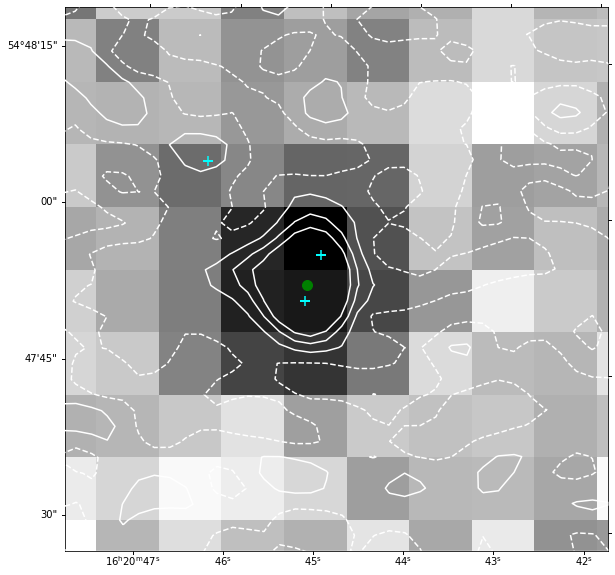

dust luminosity is 1100392156884.2244 solar_luminosities at redshift 1.0142
predicted radio flux, using q=2.7 is: 0.43516025807523867mJy
plotting 1 sources
plotting 3 sources


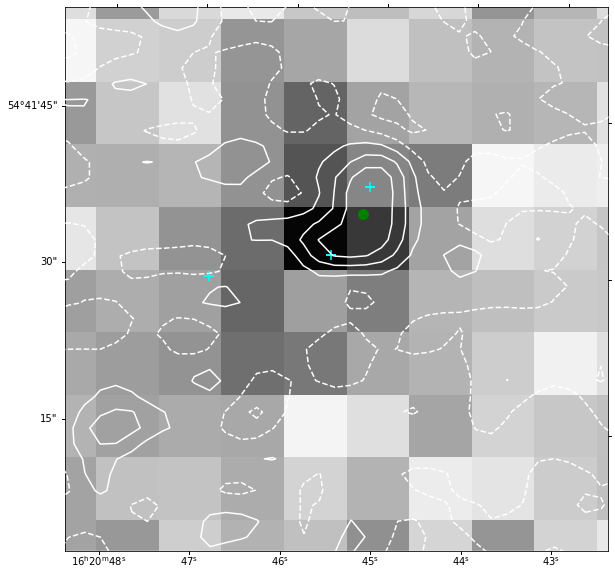

In [235]:
imfolder='../../../HELP/dmu_products/dmu19/dmu19_HELP-SPIRE-maps/data/'
pswfits=imfolder+'ELAIS-N1_SPIRE250_v1.0.fits'
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['image'].header

im250=hdulist['image'].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist['image'].header)
hdulist.close()

fname = '../lofar/deep_fields/ELAIS-N1/data/data_release/radio_image.fits'
hdulist = fits.open(fname)
radim_header = hdulist[0].header
radim_wcs = wcs.WCS(radim_header).celestial
radim_data = hdulist[0].data[0][0]
hdulist.close()

plot_params = {'marker':['o','+','s','v','X','d'],
              'col':['green','cyan','orange'],
              'size':100,
              'box_length':1/60,
              'use_redshift':[False,False,False]}
z = help_ldust[idx_help_not][mask]['redshift']
dist = cosmo.luminosity_distance(z).to(u.m).value
lum_rad_pred = 10**(np.log10(help_ldust[idx_help_not][mask]['cigale_dustlumin']/3.75E12) - 1.66)
f_rad_pred = lum_rad_pred/(4*np.pi*dist**2)/1E-29
for n in range(len(ras)):
    print('dust luminosity is {} solar_luminosities at redshift {}'.format(help_ldust[idx_help_not][mask][n]['cigale_dustlumin']/3.8E26,help_ldust[idx_help_not][mask][n]['redshift']))
    print('predicted radio flux, using q=2.7 is: {}mJy'.format(f_rad_pred[n]))
    image_plotting.plot_figure(im250,[lofar_data,help_ldust],w_250,ras[n],decs[n],plot_params,contour_data=[radim_data,radim_wcs])

In [8]:
cigale = Table.read('../lofar/deep_fields/ELAIS-N1/cigale/data/input/out/results.fits')
cigale[0]

id,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.dust.mass,bayes.dust.mass_err,bayes.dust.qpah,bayes.dust.qpah_err,bayes.dust.umin,bayes.dust.umin_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.attenuation.Av_BC,bayes.attenuation.Av_BC_err,bayes.attenuation.bessell_b,bayes.attenuation.bessell_b_err,bayes.attenuation.galex_fuv,bayes.attenuation.galex_fuv_err,bayes.attenuation.slope_BC,bayes.attenuation.slope_BC_err,bayes.attenuation.BC_to_ISM_factor,bayes.attenuation.BC_to_ISM_factor_err,bayes.attenuation.slope_ISM,bayes.attenuation.slope_ISM_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.sfh.age,bayes.sfh.age_err,bayes.sfh.burst_age,bayes.sfh.burst_age_err,bayes.sfh.f_burst,bayes.sfh.f_burst_err,best.chi_square,best.reduced_chi_square,best.agn.agn_luminosity,best.agn.beta,best.agn.fracAGN,best.agn.gamma,best.agn.luminosity,best.agn.opening_angle,best.agn.psy,best.agn.r_ratio,best.agn.scatt_luminosity,best.agn.tau,best.agn.therm_luminosity,best.attenuation.Av_BC,best.attenuation.BC_to_ISM_factor,best.attenuation.bessell_b,best.attenuation.galex_fuv,best.attenuation.slope_BC,best.attenuation.slope_ISM,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.alpha,best.dust.gamma,best.dust.luminosity,best.dust.mass,best.dust.qpah,best.dust.umin,best.lyc_absorption_f_dust,best.lyc_absorption_f_esc,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.stellar.metallicity,best.stellar.n_ly,best.stellar.n_ly_old,best.stellar.n_ly_young,best.stellar.old_young_separation_age,best.universe.age,best.universe.luminosity_distance,best.universe.redshift,best.MegaCam.u.res,best.PS1.g.res,best.PS1.r.res,best.PS1.i.res,best.PS1.z.res,best.PS1.y.res,best.HSC-g_mod.res,best.HSC-r_mod.res,best.HSC-i_mod.res,best.HSC-z_mod.res,best.HSC-Y_mod.res,best.wHSC-NB921_mod.res,best.UKIDSS.J.res,best.UKIDSS.K.res,best.IRAC.I1.res,best.IRAC.I2.res,best.IRAC.I3.res,best.IRAC.I4.res,best.mips_24,best.pacs_green,best.pacs_red,best.spire_250,best.spire_350,best.spire_500
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy
bytes22,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ILTJ160005.14+545029.2,81768695343.18811,15833013535.88725,65.85527866129229,9.781225601464877,2.0021545334695293e+38,3.7236893274580656e+37,2.538490105577217e+38,8.14974348114741e+37,2.983122579148215,0.6791046994815372,23.76136322517792,4.2227014758630546,0.006002616816136704,0.019880700502795015,1.2965189103770192,0.3464225451529704,0.7615126113658914,0.12127122839787843,2.1244151304315007,0.22699907995539995,-0.6999999999999998,1

In [9]:
lofar_cigale = join(lofar_data,cigale,keys='id',join_type='inner')
lofar_cigale[0]

id,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,FLAG_OVERLAP,Separation,help_id,RA_HELP,DEC_HELP,EBV,Z_SPEC,CLASS_STAR,MegaCam.u.res,MegaCam.u.res_err,PS1.g.res,PS1.g.res_err,PS1.r.res,PS1.r.res_err,PS1.i.res,PS1.i.res_err,PS1.z.res,PS1.z.res_err,PS1.y.res,PS1.y.res_err,HSC-g_mod.res,HSC-g_mod.res_err,HSC-r_mod.res,HSC-r_mod.res_err,HSC-i_mod.res,HSC-i_mod.res_err,HSC-z_mod.res,HSC-z_mod.res_err,HSC-Y_mod.res,HSC-Y_mod.res_err,wHSC-NB921_mod.res,wHSC-NB921_mod.res_err,UKIDSS.J.res,UKIDSS.J.res_err,UKIDSS.K.res,UKIDSS.K.res_err,IRAC.I1.res,IRAC.I1.res_err,IRAC.I2.res,IRAC.I2.res_err,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,IRAC.I3.res,IRAC.I3.res_err,IRAC.I4.res,IRAC.I4.res_err,mips_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,pacs_green,FErr_PACS_100_u,FErr_PACS_100_l,pacs_red,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,spire_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,spire_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,spire_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,AGN,optAGN,IRAGN,XrayAGN,redshift,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,hp_idx_11,hp_depth_cluster,mips_24_err,pacs_green_err,pacs_red_err,spire_250_err,spire_350_err,spire_500_err,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.dust.mass,bayes.dust.mass_err,bayes.dust.qpah,bayes.dust.qpah_err,bayes.dust.umin,bayes.dust.umin_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.attenuation.Av_BC,bayes.attenuation.Av_BC_err,bayes.attenuation.bessell_b,bayes.attenuation.bessell_b_err,bayes.attenuation.galex_fuv,bayes.attenuation.galex_fuv_err,bayes.attenuation.slope_BC,bayes.attenuation.slope_BC_err,bayes.attenuation.BC_to_ISM_factor,bayes.attenuation.BC_to_ISM_factor_err,bayes.attenuation.slope_ISM,bayes.attenuation.slope_ISM_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.sfh.age,bayes.sfh.age_err,bayes.sfh.burst_age,bayes.sfh.burst_age_err,bayes.sfh.f_burst,bayes.sfh.f_burst_err,best.chi_square,best.reduced_chi_square,best.agn.agn_luminosity,best.agn.beta,best.agn.fracAGN,best.agn.gamma,best.agn.luminosity,best.agn.opening_angle,best.agn.psy,best.agn.r_ratio,best.agn.scatt_luminosity,best.agn.tau,best.agn.therm_luminosity,best.attenuation.Av_BC,best.attenuation.BC_to_ISM_factor,best.attenuation.bessell_b,best.attenuation.galex_fuv,best.attenuation.slope_BC,best.attenuation.slope_ISM,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.alpha,best.dust.gamma,best.dust.luminosity,best.dust.mass,best.dust.qpah,best.dust.umin,best.lyc_absorption_f_dust,best.lyc_absorption_f_esc,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.st

In [10]:
mask = ~np.isnan(lofar_cigale['spire_250'])
z = lofar_cigale['redshift'][mask]
dist = cosmo.luminosity_distance(z).to(u.m).value
lum_250 = np.log10(lofar_cigale['spire_250'][mask]*1E-3 * 1E-26 * 4*np.pi*dist**2)
lum_250_lim = np.log10(5*1E-3*1E-26  *4*np.pi*dist**2)
lum_rad = np.log10(lofar_cigale['Total_flux'][mask]*4*np.pi*dist**2 * 1E-26)
flag_250 = lofar_cigale['flag_spire_250'][mask]

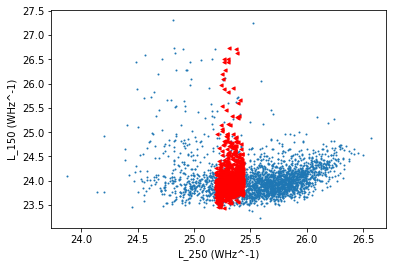

In [11]:
y = lum_rad
x = lum_250
plt.scatter(x,y,s=1)

x = lum_250_lim[flag_250]
y = lum_rad[flag_250]

plt.scatter(x,y,s=10,c='red',marker='<')
plt.xlabel('L_250 (WHz^-1)')
plt.ylabel('L_150 (WHz^-1)')
plt.show()

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_ylim(*args, **kwargs)


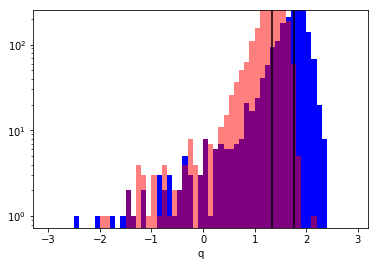

In [140]:
q = lum_250[~flag_250] - lum_rad[~flag_250]
q_lim = lum_250_lim - lum_rad
bins = np.arange(-3,3,0.1)
plt.hist(q,bins=bins,log=True,color='blue')
plt.hist(q_lim,bins=bins,log=True,color='red',alpha=0.5)

plt.vlines(np.median(q),0,500)
plt.vlines(np.median(q_lim),0,500)
plt.xlabel('q')
plt.ylim(0,250)
plt.show()

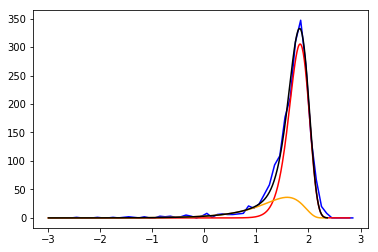

In [169]:
q_plot,_ = np.histogram(q,bins=bins)
x = get_center(bins)
y = q_plot
plt.plot(x,y,c='blue')

x = np.arange(-3,3,0.01)
y1 = log_normal(x,1,0.2,-2.8)*150
plt.plot(0-x,y1,c='red')

x = np.arange(-3,3,0.01)
y2 = log_normal(x,1,0.5,-2.37)*40
plt.plot(0-x,y2,c='orange')

y = y1+y2
plt.plot(0-x,y,c='black')

## Compare Ldust and L250to see how to best relate the selection in f250 to the Ldust plane

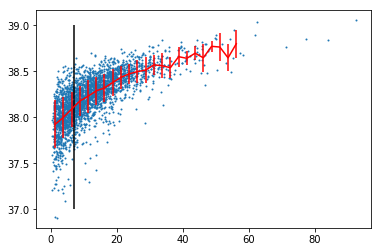

In [186]:
f250 = lofar_cigale['spire_250']
ldust = np.log10(lofar_cigale['bayes.dust.luminosity'])
plt.scatter(f250,ldust,s=1)

bins = np.arange(0,60,2.5)
x = get_center(bins)
mask = ~np.isnan(ldust)
stds,_,_ = binned_statistic(f250[mask],ldust[mask],'std',bins=bins)
means,_,_ = binned_statistic(f250[mask],ldust[mask],'mean',bins=bins)

plt.errorbar(x,means,yerr=stds,c='red')
plt.vlines(7,37,39)

plt.show()

[3.00000000e+14 2.72727273e+14 2.50000000e+14 ... 3.00090027e+11
 3.00060012e+11 3.00030003e+11]


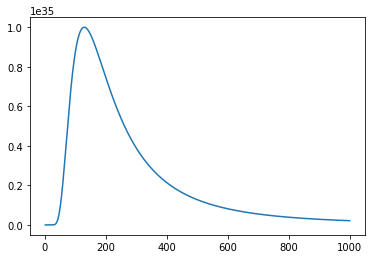

In [206]:
wave = np.arange(1,1000,0.1)
redshift = 1
wave_red = wave*(1+redshift)
flux = casey_2012(wave,1,30,50)

plt.plot(wave,flux)
tot_flux = trapz(flux,wave_red,dx=0.1)
m_250 = wave_red==250
f_250 = flux[m_250]


plt.show()

In [196]:
flux

array([inf, inf, inf, ..., inf, inf, inf])

## Compare effect of AGN selection to this

In [125]:
print('between z=0 and z=3 q changes by {} when using the Delhaize et al 2017 result'.format(delhaize_fit(0)-delhaize_fit(3)))

between z=0 and z=3 q changes by 0.6668997389452622 when using the Delhaize et al 2017 result


## Calculate median Q using survival analysis when no AGN removed

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


measured median from the detections is: 1.6519517833459432
measured median using survival analysis is: 1.6279941272791447


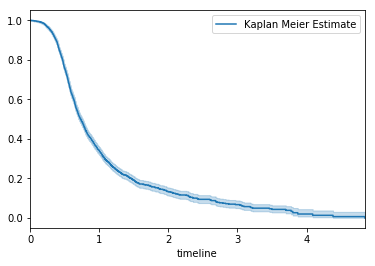

In [125]:
q = lum_250 - lum_rad
q_lim = lum_250_lim - lum_rad
const = np.max(q)
q = const - q
q_lim = const - q_lim

data = q
data[flag_250] = q_lim[flag_250]
det = (~flag_250).astype('int')
print('measured median from the detections is: {}'.format(const - np.median(data)))

kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(data, det,label='Kaplan Meier Estimate')

## Create an estimate
print('measured median using survival analysis is: {}'.format(const - kmf.median_))
kmf.plot()
plt.show()

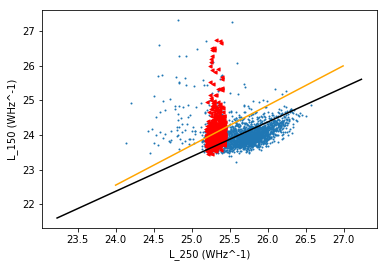

In [126]:
y = lum_rad[~flag_250]
x = lum_250[~flag_250]
plt.scatter(x,y,s=1)

x = lum_250_lim[flag_250]
y = lum_rad[flag_250]
plt.scatter(x,y,s=10,c='red',marker='<')

x = np.arange(np.min(lum_rad),np.max(lum_rad),0.1)
y = x-(const - kmf.median_)
plt.plot(x,y,c='black')

x = np.arange(24,27,0.01)
y = np.log10(gurkan_fit(10**x))
plt.plot(x,y,c='orange')


#plt.xlim(18,25)
#plt.ylim(19,26)
plt.xlabel('L_250 (WHz^-1)')
plt.ylabel('L_150 (WHz^-1)')
plt.show()

## Calculate median Q using survival analysis when removing AGN found suing CIGALE

In [76]:
np.sum(det)

1990

number of sources removed due to AGN cuts is: 11
measured median from the detections for SF is: 1.6536188070146025


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


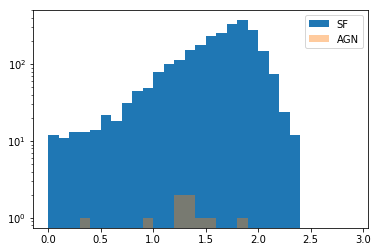

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


measured median from the detections for AGN is: 1.2869491004516291
measured median using survival analysis is for SF: 1.632517501211563
measured median using survival analysis is for AGN: 1.2292462751519402


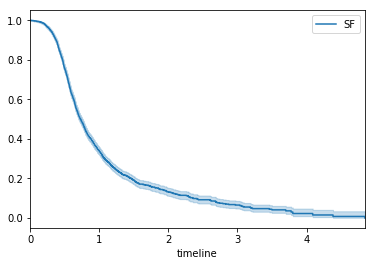

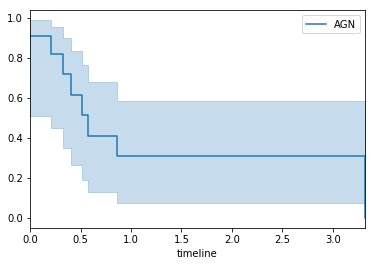

In [83]:
agn_flag = (lofar_cigale['bayes.agn.fracAGN']+lofar_cigale['bayes.agn.fracAGN_err']<0.4) 
mask = (~np.isnan(lofar_cigale['spire_250']))
agn_flag = agn_flag[mask]
print('number of sources removed due to AGN cuts is: {}'.format(np.sum(~agn_flag)))
q = lum_250[agn_flag] - lum_rad[agn_flag]
q_lim = lum_250_lim[agn_flag] - lum_rad[agn_flag]
const_sf = np.max(q)
bins = np.arange(0,3,0.1)
plt.hist(q,bins=bins,log=True,label='SF')
q = const_sf - q
q_lim = const_sf - q_lim




data = q
data[flag_250[agn_flag]] = q_lim[flag_250[agn_flag]]
det = (~flag_250[agn_flag]).astype('int')
print('measured median from the detections for SF is: {}'.format(const_sf - np.median(data)))

q = lum_250[~agn_flag] - lum_rad[~agn_flag]
q_lim = lum_250_lim[~agn_flag] - lum_rad[~agn_flag]
const_agn = np.max(q)
bins = np.arange(0,3,0.1)
plt.hist(q,bins=bins,log=True,label='AGN',alpha=0.4)
q = const_agn - q
q_lim = const_agn - q_lim


plt.legend()
plt.show()

data_agn = q
data_agn[flag_250[~agn_flag]] = q_lim[flag_250[~agn_flag]]
det_agn = (~flag_250[~agn_flag]).astype('int')
print('measured median from the detections for AGN is: {}'.format(const_agn - np.median(data_agn)))


kmf_sf = KaplanMeierFitter()
kmf_agn = KaplanMeierFitter()

## Fit the data into the model
kmf_sf.fit(data, det,label='SF')
kmf_agn.fit(data_agn, det_agn,label='AGN')
print('measured median using survival analysis is for SF: {}'.format(const_sf - kmf_sf.median_))
print('measured median using survival analysis is for AGN: {}'.format(const_agn - kmf_agn.median_))

## Create an estimate
kmf_sf.plot()
kmf_agn.plot()
plt.show()

In [54]:
const - kmf_sf.percentile(0.5)

1.594650952100661

In [96]:
thresholds = np.arange(0.01,0.4,0.01)
p_16_sf = []
p_50_sf = []
p_84_sf = []
p_16_agn = []
p_50_agn = []
p_84_agn = []
for threshold in thresholds:

    agn_flag = (lofar_cigale['bayes.agn.fracAGN']+lofar_cigale['bayes.agn.fracAGN_err']<threshold) 
    mask = (~np.isnan(lofar_cigale['spire_250']))
    agn_flag = agn_flag[mask]
    #print('number of sources removed due to AGN threshold of {} is: {}'.format(threshold,np.sum(~agn_flag)))
    q = lum_250[agn_flag] - lum_rad[agn_flag]
    q_lim = lum_250_lim[agn_flag] - lum_rad[agn_flag]
    const_sf = np.max(q)
    q = const_sf - q
    q_lim = const_sf - q_lim


    data = q
    data[flag_250[agn_flag]] = q_lim[flag_250[agn_flag]]
    det = (~flag_250[agn_flag]).astype('int')
    #print('measured median from the detections for SF is: {}'.format(const - np.median(data)))

    q = lum_250[~agn_flag] - lum_rad[~agn_flag]
    q_lim = lum_250_lim[~agn_flag] - lum_rad[~agn_flag]
    const_agn = np.max(q)
    q = const_agn - q
    q_lim = const_agn - q_lim
    data_agn = q
    data_agn[flag_250[~agn_flag]] = q_lim[flag_250[~agn_flag]]
    det_agn = (~flag_250[~agn_flag]).astype('int')
    #print('measured median from the detections for AGN is: {}'.format(const - np.median(data)))


    kmf_sf = KaplanMeierFitter()
    kmf_agn = KaplanMeierFitter()

    ## Fit the data into the model
    kmf_sf.fit(data, det,label='SF')
    kmf_agn.fit(data_agn, det_agn,label='AGN')
    #print('measured median using survival analysis is for threshold of {} for SF: {}'.format(threshold,const_sf - kmf_sf.median_))
    #print('measured median using survival analysis is for threshold of {} for AGN: {}'.format(threshold,const_agn - kmf_agn.median_))
    p_16_sf.append(const_sf - kmf_sf.percentile(0.16))
    p_50_sf.append(const_sf - kmf_sf.percentile(0.5))
    p_84_sf.append(const_sf - kmf_sf.percentile(0.84))
    p_16_agn.append(const_agn - kmf_agn.percentile(0.16))
    p_50_agn.append(const_agn - kmf_agn.percentile(0.5))
    p_84_agn.append(const_agn - kmf_agn.percentile(0.84))
    


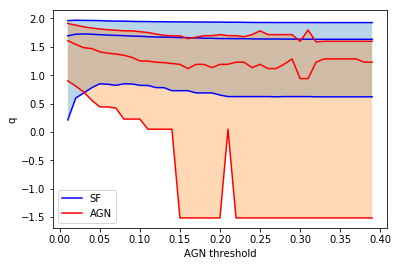

In [217]:
plt.plot(thresholds,p_50_sf,label='SF',c='blue')
plt.plot(thresholds,p_16_sf,c='blue')
plt.plot(thresholds,p_84_sf,c='blue')
plt.fill_between(thresholds,p_16_sf,p_84_sf,alpha=0.3)
plt.plot(thresholds,p_16_agn,label='AGN',c='red')
plt.plot(thresholds,p_50_agn,c='red')
plt.plot(thresholds,p_84_agn,c='red')
plt.fill_between(thresholds,p_16_agn,p_84_agn,alpha=0.3)
plt.xlabel('AGN threshold')
plt.ylabel('q')
plt.legend()
plt.show()

In [225]:
interest_agn[0]

id,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,NUMBER,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,FLAG_OVERLAP,Separation,help_id,RA_HELP,DEC_HELP,EBV,Z_SPEC,CLASS_STAR,MegaCam.u.res,MegaCam.u.res_err,PS1.g.res,PS1.g.res_err,PS1.r.res,PS1.r.res_err,PS1.i.res,PS1.i.res_err,PS1.z.res,PS1.z.res_err,PS1.y.res,PS1.y.res_err,HSC-g_mod.res,HSC-g_mod.res_err,HSC-r_mod.res,HSC-r_mod.res_err,HSC-i_mod.res,HSC-i_mod.res_err,HSC-z_mod.res,HSC-z_mod.res_err,HSC-Y_mod.res,HSC-Y_mod.res_err,wHSC-NB921_mod.res,wHSC-NB921_mod.res_err,UKIDSS.J.res,UKIDSS.J.res_err,UKIDSS.K.res,UKIDSS.K.res_err,IRAC.I1.res,IRAC.I1.res_err,IRAC.I2.res,IRAC.I2.res_err,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,IRAC.I3.res,IRAC.I3.res_err,IRAC.I4.res,IRAC.I4.res_err,mips_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,pacs_green,FErr_PACS_100_u,FErr_PACS_100_l,pacs_red,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,spire_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,spire_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,spire_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,AGN,optAGN,IRAGN,XrayAGN,redshift,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,hp_idx_11,hp_depth_cluster,mips_24_err,pacs_green_err,pacs_red_err,spire_250_err,spire_350_err,spire_500_err,bayes.stellar.m_star,bayes.stellar.m_star_err,bayes.sfh.sfr10Myrs,bayes.sfh.sfr10Myrs_err,bayes.dust.luminosity,bayes.dust.luminosity_err,bayes.dust.mass,bayes.dust.mass_err,bayes.dust.qpah,bayes.dust.qpah_err,bayes.dust.umin,bayes.dust.umin_err,bayes.agn.fracAGN,bayes.agn.fracAGN_err,bayes.attenuation.Av_BC,bayes.attenuation.Av_BC_err,bayes.attenuation.bessell_b,bayes.attenuation.bessell_b_err,bayes.attenuation.galex_fuv,bayes.attenuation.galex_fuv_err,bayes.attenuation.slope_BC,bayes.attenuation.slope_BC_err,bayes.attenuation.BC_to_ISM_factor,bayes.attenuation.BC_to_ISM_factor_err,bayes.attenuation.slope_ISM,bayes.attenuation.slope_ISM_err,bayes.sfh.tau_main,bayes.sfh.tau_main_err,bayes.sfh.age,bayes.sfh.age_err,bayes.sfh.burst_age,bayes.sfh.burst_age_err,bayes.sfh.f_burst,bayes.sfh.f_burst_err,best.chi_square,best.reduced_chi_square,best.agn.agn_luminosity,best.agn.beta,best.agn.fracAGN,best.agn.gamma,best.agn.luminosity,best.agn.opening_angle,best.agn.psy,best.agn.r_ratio,best.agn.scatt_luminosity,best.agn.tau,best.agn.therm_luminosity,best.attenuation.Av_BC,best.attenuation.BC_to_ISM_factor,best.attenuation.bessell_b,best.attenuation.galex_fuv,best.attenuation.slope_BC,best.attenuation.slope_ISM,best.attenuation.stellar.old,best.attenuation.stellar.young,best.dust.alpha,best.dust.gamma,best.dust.luminosity,best.dust.mass,best.dust.qpah,best.dust.umin,best.lyc_absorption_f_dust,best.lyc_absorption_f_esc,best.sfh.age,best.sfh.burst_age,best.sfh.f_burst,best.sfh.integrated,best.sfh.sfr,best.sfh.sfr100Myrs,best.sfh.sfr10Myrs,best.sfh.tau_burst,best.sfh.tau_main,best.stellar.age_m_star,best.stellar.imf,best.stellar.lum_ly,best.stellar.lum_ly_old,best.stellar.lum_ly_young,best.stellar.m_gas,best.stellar.m_gas_old,best.stellar.m_gas_young,best.stellar.m_star,best.stellar.m_star_old,best.stellar.m_star_young,best.st

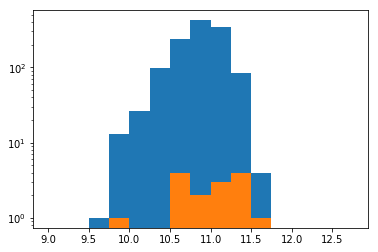

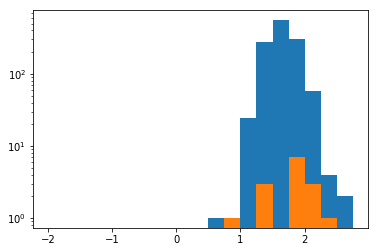

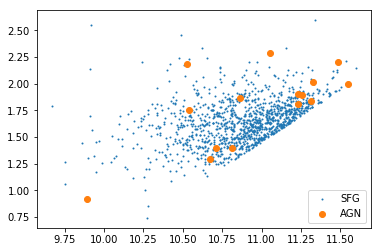

In [232]:
q = lum_250 - lum_rad
mask = ~np.isnan(lofar_cigale['spire_250'])
agn_flag = (lofar_cigale['bayes.agn.fracAGN'][mask]+lofar_cigale['bayes.agn.fracAGN_err'][mask]<0.3)
interest_agn = lofar_cigale[~np.isnan(lofar_cigale['spire_250'])][(q>1.0) & ~agn_flag]

agn_flag = (lofar_cigale['bayes.agn.fracAGN'][mask]+lofar_cigale['bayes.agn.fracAGN_err'][mask]<0.01)
ref_sfg = lofar_cigale[~np.isnan(lofar_cigale['spire_250'])][(q>1.5) & ~agn_flag]

bins = np.arange(9,13,0.25)
y = np.log10(ref_sfg['bayes.stellar.m_star'])
plt.hist(y,bins=bins,log=True)
y = np.log10(interest_agn['bayes.stellar.m_star'])
plt.hist(y,bins=bins,log=True)
plt.show()

bins = np.arange(-2,3,0.25)
y = np.log10(ref_sfg['bayes.sfh.sfr10Myrs'])
plt.hist(y,bins=bins,log=True)
y = np.log10(interest_agn['bayes.sfh.sfr10Myrs'])
plt.hist(y,bins=bins,log=True)
plt.show()

x = np.log10(ref_sfg['bayes.stellar.m_star'])
y = np.log10(ref_sfg['bayes.sfh.sfr10Myrs'])
plt.scatter(x,y,label='SFG',s=1)
x = np.log10(interest_agn['bayes.stellar.m_star'])
y = np.log10(interest_agn['bayes.sfh.sfr10Myrs'])
plt.scatter(x,y,label='AGN')
plt.legend()
plt.show()

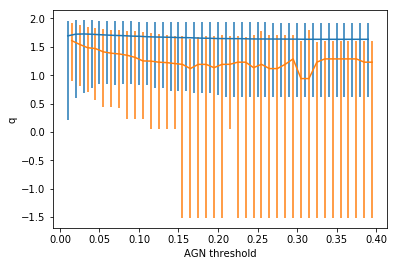

In [211]:
yerr_u = np.array(p_84_sf) - np.array(p_50_sf)
yerr_l = np.array(p_50_sf) - np.array(p_16_sf)
plt.errorbar(thresholds,p_50_sf,yerr=[yerr_l,yerr_u])
yerr_u = np.array(p_84_agn) - np.array(p_50_agn)
yerr_l = np.array(p_50_agn) - np.array(p_16_agn)
plt.errorbar(thresholds+0.005,p_50_agn,yerr=[yerr_l,yerr_u])
plt.xlabel('AGN threshold')
plt.ylabel('q')
plt.show()

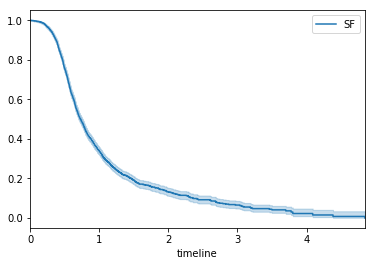

In [102]:
kmf_sf.plot()

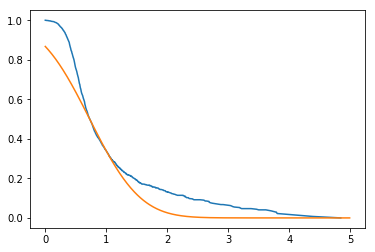

In [118]:
x = kmf_sf.timeline
y = 1-np.array(kmf_sf.cumulative_density_['SF'])
plt.plot(x,y)

mean = kmf_sf.percentile(0.5)
std = (kmf_sf.percentile(0.16) - kmf_sf.percentile(0.84))/2
x = np.arange(0,5,0.01)
y = gaus_cdf(x,[mean,std])
plt.plot(x,1-y)

In [121]:
y = 1-np.array(kmf_sf.cumulative_density_['SF'])
kstest(y,gaus_cdf,args=[[mean,std]])

KstestResult(statistic=0.33871910242419756, pvalue=2.3368030156067966e-271)

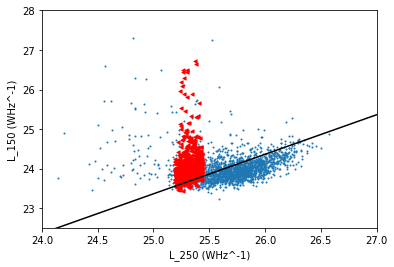

In [23]:
y = lum_rad[agn_flag & ~flag_250]
x = lum_250[agn_flag & ~flag_250]
plt.scatter(x,y,s=1)

x = lum_250_lim[agn_flag][flag_250[agn_flag]]
y = lum_rad[agn_flag][flag_250[agn_flag]]
plt.scatter(x,y,s=10,c='red',marker='<')

x = np.arange(17,28,1)
y = x-(const - kmf.median_)
plt.plot(x,y,c='black')


plt.xlim(24,27)
plt.ylim(22.5,28)
plt.xlabel('L_250 (WHz^-1)')
plt.ylabel('L_150 (WHz^-1)')
plt.show()

## Calculate median Q using survival analysis when removing AGN found using MIR colours

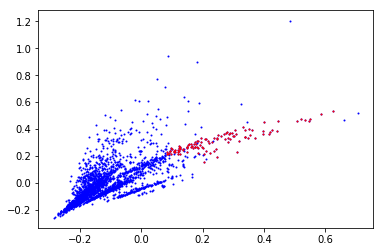

number of sources removed due to AGN cuts is: 107
measured median from the detections is: 1.6571818150390119
measured median using survival analysis is: 1.638674458220624


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/numpy/core/fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


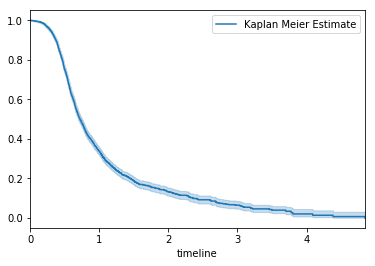

In [24]:
i1 = lofar_cigale['best.IRAC.I1.res']
i2 = lofar_cigale['best.IRAC.I2.res']
i3 = lofar_cigale['best.IRAC.I3.res']
i4 = lofar_cigale['best.IRAC.I4.res']
agn_flag = ~donley_agn(i1,i2,i3,i4,)
mask = (~np.isnan(lofar_cigale['spire_250']))
agn_flag = agn_flag[mask]
print('number of sources removed due to AGN cuts is: {}'.format(np.sum(~agn_flag)))
q = lum_250[agn_flag] - lum_rad[agn_flag]
q_lim = lum_250_lim[agn_flag] - lum_rad[agn_flag]
const = np.max(q)
q = const - q
q_lim = const - q_lim


data = q
data[flag_250[agn_flag]] = q_lim[flag_250[agn_flag]]
det = (~flag_250[agn_flag]).astype('int')
print('measured median from the detections is: {}'.format(const - np.median(data)))


kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(data, det,label='Kaplan Meier Estimate')
print('measured median using survival analysis is: {}'.format(const - kmf.median_))

## Create an estimate
kmf.plot()
plt.show()